# CARE Prediction
Please run the `1_CARETraining.ipynb` notebook before going through this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from ppn2v.unet.model import UNet
from ppn2v import utils, prediction, training
from ppn2v.noise_models import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calculate the 'mean' and 'std' for normalization
path='../../../data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_CareTraining.ipynb```.

In [3]:
dataName = 'convallaria' # Use the same name as used in 1_CareTraining.ipynb. This is a part of model name created in 1_CareTraining.ipynb 
nameModel=dataName+'_care'

In [4]:
# Load the network, created in the '1_CareTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR CARE 36.67757308707901
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR CARE 36.61338554308841
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR CARE 36.62792815887328
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR CARE 36.636421187587246
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR CARE 36.6520749535693
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR CARE 36.6341909011414
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR CARE 36.658750453409965
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR CARE 36.65562709298151
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR CARE 36.74228569661676
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR CARE 36.67616253244131
-------

image: 80
PSNR input 28.957840957402226
PSNR CARE 36.66666828117033
-----------------------------------
image: 81
PSNR input 28.940414811710117
PSNR CARE 36.63509523956118
-----------------------------------
image: 82
PSNR input 28.991915288787613
PSNR CARE 36.71381565173662
-----------------------------------
image: 83
PSNR input 29.023941316831703
PSNR CARE 36.67502867726126
-----------------------------------
image: 84
PSNR input 28.979363428547718
PSNR CARE 36.67100522214739
-----------------------------------
image: 85
PSNR input 28.977253844527432
PSNR CARE 36.75739501581565
-----------------------------------
image: 86
PSNR input 28.93295570861992
PSNR CARE 36.595458219806474
-----------------------------------
image: 87
PSNR input 28.911831115485445
PSNR CARE 36.56933157191616
-----------------------------------
image: 88
PSNR input 28.98025614483497
PSNR CARE 36.6414381391844
-----------------------------------
image: 89
PSNR input 28.94848133894456
PSNR CARE 36.61567774793568

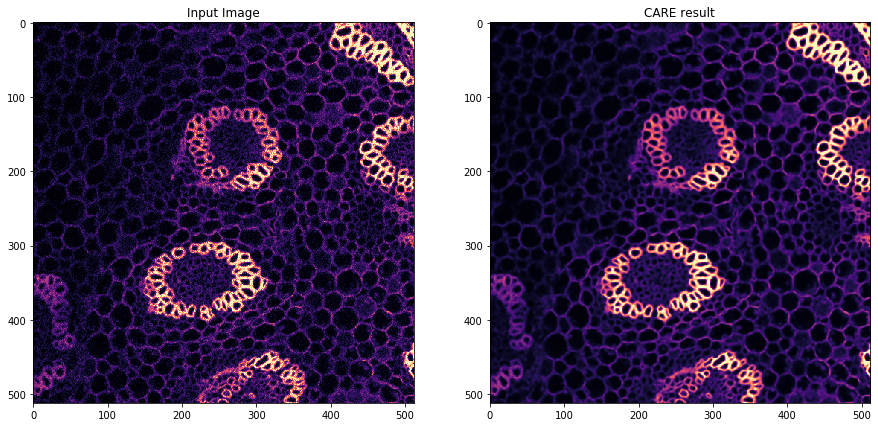

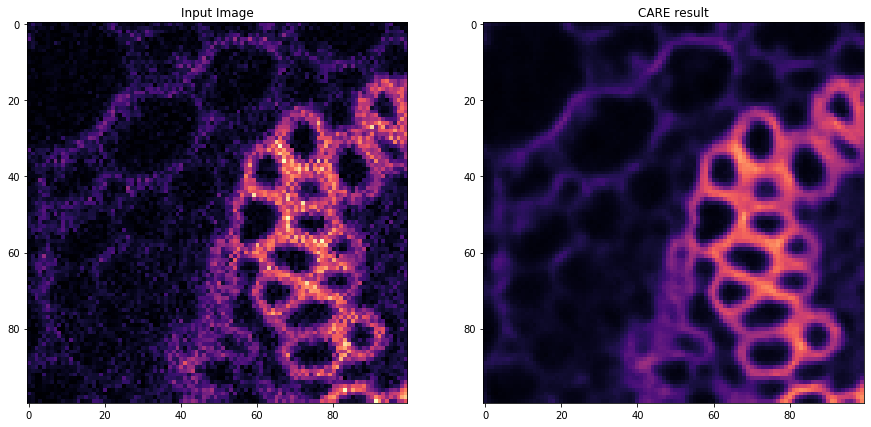

Avg PSNR CARE: 36.65602418854569 +-(2SEM) 0.008584735911017728


In [5]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=utils.PSNR(gt, careResult, rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input", utils.PSNR(gt, im, rangePSNR))
    print ("PSNR CARE", carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/raw_image.png', im[100:200,150:250])

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/CARE_denoised_image.png', careResult[100:200,150:250])
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )